# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Problem solving intentions

As I do my project, I intend to seek to discover patterns between customer demographics and willingness to take up offers. In particular, I will seek to find what kind of Starbucks offers are taken up by which group of consumers.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Assessing Data

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio['difficulty'].value_counts()

10    4
5     2
0     2
7     1
20    1
Name: difficulty, dtype: int64

This column seems mostly good, but it could be renamed as "min_spend", given that the meaning of "difficulty" is unclear in this context.

In [5]:
portfolio['duration'].value_counts()

7     4
10    2
5     2
4     1
3     1
Name: duration, dtype: int64

This column seems fine.

In [6]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [7]:
portfolio['id'].value_counts()

0b1e1539f2cc45b7b9fa7c272da2e1d7    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
ae264e3637204a6fb9bb56bc8210ddfd    1
2906b810c7d4411798c6938adc9daaa5    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
f19421c1d4aa40978ebb69ca19b0e20d    1
3f207df678b143eea3cee63160fa8bed    1
fafdcd668e3743c1bb461111dcafc2a4    1
5a8bc65990b245e5a138643cd4eb9837    1
Name: id, dtype: int64

In [8]:
portfolio['reward'].value_counts()

5     3
10    2
2     2
0     2
3     1
Name: reward, dtype: int64

This column seems good as well.

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [11]:
profile['age'].value_counts().head()

118    2175
58      408
53      372
51      363
54      359
Name: age, dtype: int64

2175 people have their age marked as 118. This is very suspicious. I cannot imagine that one-sixth of the customer set would be this old. This is ridiculous in any way I think about it. It is more likely that when a customer's age is unknown, the program defaults to 1900 as the birth year. I will have to fix it in some way. One solution could be to replace 118 with NaN first, and then impute the median value.

In [12]:
profile['became_member_on'].head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

The became_member_on column should be of datetype, not int form. I would also consider changing the date format, maybe by adding dashed between the year, month, and day. I will however keep the year-month-day order, in order to prevent confusion from day/month vs. month/day.

In [13]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

8484 individuals are marked as men, 6129 as women, 212 as other, and 2175 are "None" missing values. I might merge the "other" and "None" into an "unknown" value.

In [14]:
profile['id'].value_counts()

20e6b5b7907a41d589576012963bde5d    1
74332b3675714b6ca36e9ef95e5feb8a    1
73c1ea7bacde40a294d66d4be891cc21    1
8124f214cc314a44941899319f412502    1
056495e7cd754a6c81b25d4ae5ca5e02    1
401540c42ab34de1b873b34bf46e9149    1
fe165534ac61475f90835daf595a0899    1
b3012ef6a5e440799b1f08f4f5ed44b3    1
88d9dc7a5c504f51baa0094af43bf774    1
ba9fb3e4a7084361914c1647d871d27e    1
dba37373b11f4eef8918bf015c9161c1    1
d4dd357e57854084b74013a31ae8c79f    1
8431c16f8e1d440880db371a68f82dd0    1
7266ae3ba556431295c89e6ad3add995    1
8319fc0fd5294e6daf21fe0b1116c71e    1
6e7a4ed8cccc4344a26fd66b5734141d    1
5e8b47c6fcec4da0afbe79062da79e04    1
f4698ee1109f4baf8d255297c8efd354    1
acef018f388441a6a8c192906b780fb4    1
d7af537a9c1c47d8a89913699c4b4343    1
0799a98aeb994b8d9a719deccd90ed39    1
4fdfb0cfb2164596ac8df0661a13330a    1
a5e2537543c042c09349d14ce47cf083    1
dc1b785727f0446e8d5076d9c60cc2e9    1
e8db8c4fb4fd40119ebe05310de8cca7    1
ee390b06407f4751b148a82a59b66dce    1
f27f85212c23

Every id appears to be unique. Therefore, this column is good as it is.

In [15]:
profile['income'].value_counts()

73000.0     314
72000.0     297
71000.0     294
57000.0     288
74000.0     282
53000.0     282
56000.0     281
52000.0     281
54000.0     272
70000.0     270
51000.0     268
61000.0     258
64000.0     258
55000.0     254
50000.0     253
60000.0     251
59000.0     243
75000.0     243
67000.0     242
58000.0     239
65000.0     238
62000.0     229
68000.0     228
31000.0     223
66000.0     222
32000.0     216
33000.0     213
39000.0     209
37000.0     209
63000.0     206
           ... 
82000.0     126
95000.0     126
97000.0     124
99000.0     123
90000.0     114
98000.0     112
94000.0     106
91000.0     106
30000.0      88
100000.0     87
109000.0     62
103000.0     59
118000.0     58
110000.0     58
105000.0     58
108000.0     57
106000.0     56
111000.0     55
104000.0     55
113000.0     54
119000.0     54
114000.0     53
115000.0     50
101000.0     48
102000.0     48
116000.0     46
107000.0     45
112000.0     45
117000.0     32
120000.0     13
Name: income, Length: 91

This column appears reasonable. I might change the datatype from float to int, given that all the values appear to end with ".0", making the float type unnecessary.

In [16]:
profile[profile['age'] == 118]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


Coming to think of it, it appears that the data which has an age of 118 also has a "None" gender and a NaN value for income. Needless to say this type of data is almost completely useless for any purpose. I will later delete all rows with 118 as the age.

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


No missing values are present in this dataset at all.

In [19]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Four possible options are present here - transaction, offer received, offer viewed and offer completed.

In [20]:
transcript['person'].value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
5e60c6aa3b834e44b822ea43a3efea26    48
d0a80415b84c4df4908b8403b19765e3    48
28681c16026943e68f26feaccab0907f    46
a42ed50acc4d4b25bca647c9e0b916ad    46
b1f4ece7d49342628a9ed77aee2cde58    46
bd2cdd691aca4bb0a0e039979ee5de5c    46
ab25fd6fbd5040f880751921e4029757    44
9ae56116908640fc83477982da0aaec4    43
4142f5e23db741b1af4be0287dc91c1c    43
ca265792e65949d79b2b0e91bdd31c57    43
86e9d338b85b4177b369fe6b0ad4fed3    43
d087fd0166404163b7d1e1e7cf2a9ac7    43
cd9bac9e8aea4609929a55b9b468c88e    42
0ebc3c4c39234ab6a2701fe2525705a9    42
8e7d398d4bd948e397e201ad2bd5cce8    42
edc7b04392144da9979f3077095f268a    42
0d74b166a5e54b269795dbaf38c6dfae    42
40ce078d5b2a43d19138a788754520be    42
2ddc7d63c32d4606a7a45e3e70439b44    41
81a263ee0b8544b6a8910ee690cc6edd    41
5da599f0f0ca40a6916e28487a55e655    41
a6fce370a2ce4df995fc4899bfeb3b6a    41
417c8e42cba54dd0ba1ea7ee0

Notable that the just about every customer in the dataset appears more than once.

In [21]:
transcript['time'].value_counts()

408    17030
576    17015
504    16822
336    16302
168    16150
0      15561
414     3583
510     3514
582     3484
588     3222
516     3153
420     3146
342     3017
594     2937
426     2908
174     2823
522     2783
600     2739
432     2690
180     2659
348     2655
438     2591
606     2585
528     2569
6       2506
534     2465
354     2422
186     2406
612     2375
444     2367
       ...  
270     1294
264     1260
252     1260
690     1260
96      1248
90      1235
276     1206
288     1199
102     1193
282     1175
120     1168
714     1130
702     1115
114     1106
108     1104
300     1073
708     1048
306     1034
312     1031
294     1010
126      983
324      968
138      968
144      955
132      952
318      940
330      938
156      914
162      910
150      894
Name: time, Length: 120, dtype: int64

This column seems good. The time can vary from zero hours to hundreds.

In [22]:
transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

This column includes the offer id in some cases, and an amount in others. Could be tricky later on.

# Cleaning Data

In [23]:
portfolio.rename(index=str, columns={"difficulty": "min_spend"}, inplace=True)

In [24]:
portfolio.head()

,channels,min_spend,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [25]:
profile = profile[profile['age'] != 118]

In [26]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


I was remarkably lucky here. By removing the rows with an age of 118, I managed to get rid of missing values altogether from the dataset.

In [27]:
profile['became_member_on']= pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [28]:
profile.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [29]:
profile['income'] = profile['income'].astype(int)

In [30]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [31]:
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0])
#Extracting value type
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0]) 
#Extracting the actual value

In [32]:
transcript.head()

,event,person,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


In [33]:
transcript['value_type'].value_counts()

amount      138953
offer id    134002
offer_id     33579
Name: value_type, dtype: int64

In [34]:
transcript['value_type'] = transcript['value_type'].map({'offer_id' : 'offer_id', 'offer id' : 'offer_id', 'amount':'amount'})

In [35]:
transcript = transcript.rename(columns={'person': 'id'})

In [36]:
df_merged = pd.merge(profile, transcript, on = 'id')

In [37]:
df_merged.head()

,age,became_member_on,gender,id,income,event,time,value,value_type
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,18,21.51,amount
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,144,32.28,amount
2,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id
3,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,offer received,504,3f207df678b143eea3cee63160fa8bed,offer_id
4,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,528,23.22,amount


# Visualizations

I will now do some visualizations to display certain forms of correlation.

Text(0,0.5,'Income (US dollars)')

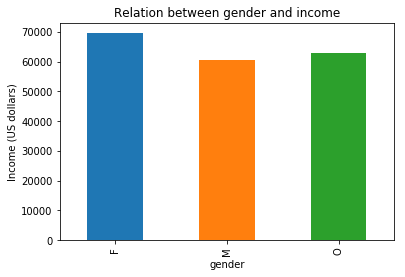

In [38]:
df_merged.groupby(['gender']).mean()['income'].plot.bar()
plt.title('Relation between gender and income')
plt.ylabel('Income (US dollars)')

The difference in averager income when taking gender into account is not too larger. Surprisingly enough, women have a higher average income than men in this data.

Text(0,0.5,'Income (US dollars)')

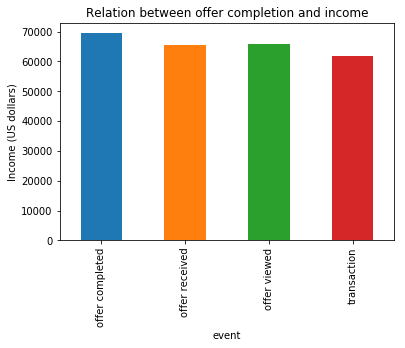

In [39]:
df_merged.groupby(['event']).mean()['income'].plot.bar()
plt.title('Relation between offer completion and income')
plt.ylabel('Income (US dollars)')

The difference is not huge, but those who completed an offer do tend to have a higher income on average.

Text(0,0.5,'Reward (US dollars)')

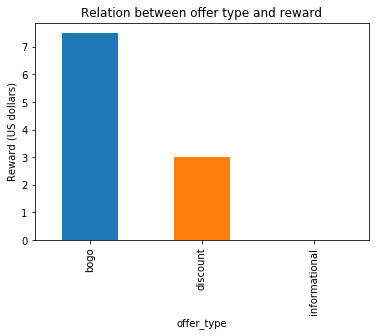

In [40]:
portfolio.groupby(['offer_type']).mean()['reward'].plot.bar()
plt.title('Relation between offer type and reward')
plt.ylabel('Reward (US dollars)')

Clear differences are visible here. Informational offers do not provide any form of financial reward. Discounts provide three dollars on average of rewards. "Buy one, get one later" are even better, providing on average over seven dollars.

Text(0,0.5,'Minimum spending required (US dollars)')

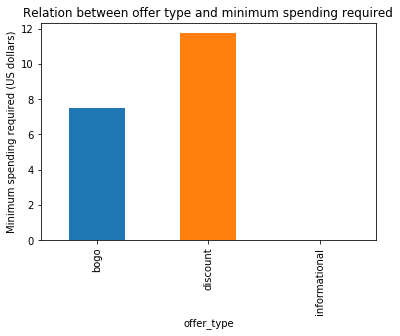

In [41]:
portfolio.groupby(['offer_type']).mean()['min_spend'].plot.bar()
plt.title('Relation between offer type and minimum spending required')
plt.ylabel('Minimum spending required (US dollars)')

Similar to the previous findings, informational offers do not require customers to pay a single cent. On the other hand, "buy one get one later" require consumers to pay almost eight dollars on average. Discounts have still larger financial requirements, with an average minimum spending of almost twelve dollars.

Text(0,0.5,'Duration (days)')

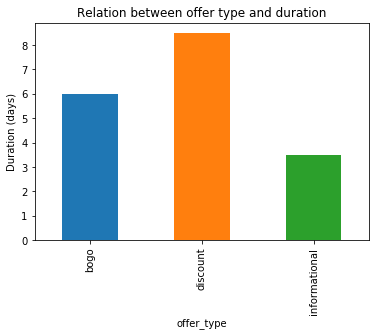

In [42]:
portfolio.groupby(['offer_type']).mean()['duration'].plot.bar()
plt.title('Relation between offer type and duration')
plt.ylabel('Duration (days)')

On average, discount offers are open for the longest period of time, over eight days. "Buy one, get one later" tend to be open for about six days on average, whereas informational offers are open for a mean value of less than four days.

## Predicting time from income and age.

I will now seek to predict the time (in hours) since the test started from income and age of customers.

In [68]:
df_merged.head()

,age,became_member_on,gender,id,income,event,time,value,value_type
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,18,21.51,amount
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,144,32.28,amount
2,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id
3,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,offer received,504,3f207df678b143eea3cee63160fa8bed,offer_id
4,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,528,23.22,amount


In [44]:
X = df_merged[['income', 'age']]
y= df_merged['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)
lin_model = LinearRegression(normalize=True)
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [45]:
pred = lin_model.predict(X_test)

In [46]:
rsquared_score = r2_score(y_test, pred)
length_y_test = len(y_test)

In [47]:
"The r-squared score for the model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for the model was 4.004581202754487e-05 on 81829 values.'

The R-squared score here is essentially zero. This means that I cannot explain any part of the variance in time with the income or age of consumers.

In [48]:
df_value = df_merged.ix[(df_merged['value_type'] == 'amount'), ['age','became_member_on', 'gender', 'id', 'income',
                                                              'event', 'time', 'value', 'value_type']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [49]:
df_merged['value_type'].value_counts()

offer_id    148805
amount      123957
Name: value_type, dtype: int64

In [50]:
df_value.head()

,age,became_member_on,gender,id,income,event,time,value,value_type
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,18,21.51,amount
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,144,32.28,amount
4,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,528,23.22,amount
8,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,transaction,132,19.89,amount
10,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,transaction,144,17.78,amount


Here I created a new dataset that only includes rows where the "value_type" was an actual amount. I will try to predict the value from income.

## Predicting value from income.

In [51]:
X = df_value[['income']]
y= df_value['value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)
lin_model = LinearRegression(normalize=True)
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [52]:
pred = lin_model.predict(X_test)

In [53]:
rsquared_score = r2_score(y_test, pred)
length_y_test = len(y_test)

In [54]:
"The r-squared score for the model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for the model was 0.05433391868695048 on 37188 values.'

The R-Squared score here is 0.05. While slightly higher than in the previous example, this still means that very little of the variance in value can be explained by income.

## New dataset

The half of my dataset with an amount value is dealt with in the previous lines. I will now seek to deal with the other part of the df_merged dataset that had a reference to a specific offer.

In [55]:
df_offer = df_merged.ix[(df_merged['value_type'] == 'offer_id'), ['age','became_member_on', 'gender', 'id', 'income',
                                                              'event', 'time', 'value', 'value_type']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [56]:
df_value.head()

,age,became_member_on,gender,id,income,event,time,value,value_type
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,18,21.51,amount
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,144,32.28,amount
4,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000,transaction,528,23.22,amount
8,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,transaction,132,19.89,amount
10,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,transaction,144,17.78,amount


In [57]:
df_offer.rename(index=str, columns={"value":"offer_id"}, inplace=True)

In [58]:
portfolio.rename(index=str, columns={"id":"offer_id"}, inplace=True)

In [59]:
df_portfolio = pd.merge(portfolio, df_offer, on = 'offer_id')

In [60]:
df_portfolio.head()

,channels,min_spend,duration,offer_id,offer_type,reward,age,became_member_on,gender,id,income,event,time,value_type
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,offer received,408,offer_id
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,offer viewed,408,offer_id
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,offer completed,510,offer_id
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000,offer received,408,offer_id
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000,offer completed,426,offer_id


Text(0,0.5,'Minimum spending (US dollars)')

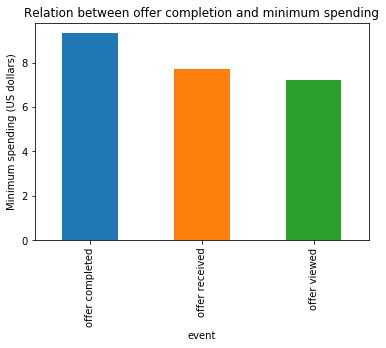

In [61]:
df_portfolio.groupby(['event']).mean()['min_spend'].plot.bar()
plt.title('Relation between offer completion and minimum spending')
plt.ylabel('Minimum spending (US dollars)')

Offers that required consumers to spend more had higher rates of completion.

Text(0,0.5,'Reward (US dollars)')

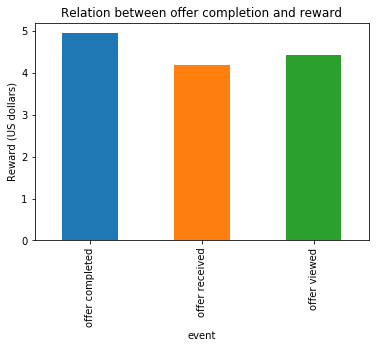

In [62]:
df_portfolio.groupby(['event']).mean()['reward'].plot.bar()
plt.title('Relation between offer completion and reward')
plt.ylabel('Reward (US dollars)')

Offers with higher rewards were on average completed more often.

Text(0,0.5,'Duration (Days)')

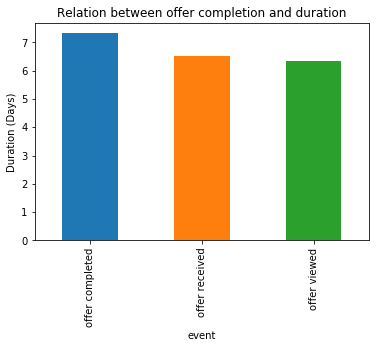

In [63]:
df_portfolio.groupby(['event']).mean()['duration'].plot.bar()
plt.title('Relation between offer completion and duration')
plt.ylabel('Duration (Days)')

The difference is not huge, but completed offers tended to be open for slightly longer. 

# Improvements

My previous linear regression models produced mediocre results. In order to seek a possible improvement, I will try and use more factors to predict a certain variable. Whereas previously I tried to predict a value of a transaction only from the income, this time I will use the other quantitative variables in df_value as well - time and age.

In [64]:
X = df_value[['income', 'age', 'time']]
y= df_value['value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)
lin_model = LinearRegression(normalize=True)
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [65]:
pred = lin_model.predict(X_test)

In [66]:
rsquared_score = r2_score(y_test, pred)
length_y_test = len(y_test)

In [67]:
"The r-squared score for the model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for the model was 0.054802037327027486 on 37188 values.'

Unfortunately, despite adding age and time to the model, the R-squared score remains virtually unchanged, at 0.05 after rounding.

I will try and improve my other linear regression model by adding additional x-factors. I will train this model on the df_portfolio dataset in order to prevent errors from non-numeric values.

In [71]:
df_portfolio.head()

,channels,min_spend,duration,offer_id,offer_type,reward,age,became_member_on,gender,id,income,event,time,value_type
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,offer received,408,offer_id
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,offer viewed,408,offer_id
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000,offer completed,510,offer_id
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000,offer received,408,offer_id
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000,offer completed,426,offer_id


# Conclusion

As part of my project, I analyzed Starbucks data on consumer behavior. The data included references to various promotions and their length, as well as various demographic information on consumers. After loading, assessing and cleaning the data, I carried out certain visualizations, showing how various factors were related to each other. I also conducted two linear regression tests. One sought to determine how much of the variation in time could be explained by income and age. The other one sought to explain how much of the variation of a transaction's value could be explained by income. Unfortunately, the R-scores I got from these models were poor - 0 from the first one, 0.05 from the second one.

This project had both its easy and difficult sides. On the easier side, the data was easy to deal with as far as missing values were concerned. 2175 rows in the "profile" dataset lacked gender and income data, and had an outlandish age - 118 (probably inserted as a default with a birth year of 1900). Apart from these rows, the rest of the data did not have missing values. Therefore, I did not have to make difficult decisions like whether to, say, delete rows that have income but not gender data. On the difficult side, it was not easy when the transcript data set had either an "offer id" or an "amount" value in one of the columns. This made it essentially impossible to combine the three datasets together. I had to split up the transcript dataset depending on whether the "offer id" or the "amount" was given. I tried to improve my linear regression model by adding more x-factors. Unfortunately, my R-squared score did not seem to improve at all.